## Data EDA ##

In this notebook, we'll look at the historical stock and financial data that will be used to train our reinforcement learning agent. The data herein consists of price and volume information for the 10 stocks that we'll use as the trading universe and 14 financial time series that are regularly used to evaluate the health of the market and economy. These additional financial time series will be available to the agent to help it make more informed trading decisions. The data herein has already undergone various data cleaning procedures, such as combining the data from different data sources, removing or filling in null/nan values, etc. However, we haven't done any feature engineering yet as we'll save that for when we try to train the agent.

We'll start by importing some helpful libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

**Stock Data**

First, we'll look at the stocks that will make up the market for the agent.

In [5]:
stock_tickers = ['PG', 'JNJ', 'AAPL', 'MSFT', 'XOM', 
                 'JPM', 'BA', 'KO', 'WMT', 'DIS']

In [6]:
meta_data_file = './marketenv/environments/market_data/stock_meta_data.csv'
meta_data = pd.read_csv(meta_data_file)
meta_data = meta_data.loc[meta_data['ticker'].isin(stock_tickers), :]
meta_data

,name,ticker,exchangeCode,startDate,endDate,description
2,Apple Inc,AAPL,NASDAQ,1980-12-12,2019-10-23,"Apple Inc. (Apple) designs, manufactures and m..."
3,The Boeing Company,BA,NYSE,1962-01-02,2019-10-23,Boeing Business Jets offers a portfolio of ult...
7,The CocaCola Company,KO,NYSE,1962-01-02,2019-10-23,The Coca-Cola Company is a total beverage comp...
8,The Walt Disney Company,DIS,NYSE,1962-01-02,2019-10-23,"Disney Parks, Experiences and Products brings ..."
9,Exxon Mobil Corp,XOM,NYSE,1970-01-02,2019-10-23,Exxon Mobil Corporation (Exxon Mobil) is a man...
14,Johnson Johnson,JNJ,NYSE,1970-01-02,2019-10-23,"At Johnson & Johnson, we believe good health i..."
15,JPMorgan Chase Company,JPM,NYSE,1983-12-30,2019-10-23,JPMorgan Chase & Co. is a leading global finan...
18,Microsoft Corp,MSFT,NASDAQ,1986-03-13,2019-10-23,"Microsoft (Nasdaq ""MSFT"" @microsoft) enables d..."
21,The Procter Gamble Company,PG,NYSE,1970-01-02,2019-10-23,P&G serves consumers around the world with one...
26,WalMart Stores Inc,WMT,NYSE,1972-08-25,2019-10-23,"Wal-Mart Stores, Inc. (Walmart) operates retai..."


The 10 stocks chosen are all large, mature companies from the DJIA. They span multiple industries, including technology (e.g., Apple and Microsoft), banking and finance (e.g., JPMorgan), and consumer products (e.g., The Procter Gamble Company). Historical data was pulled from May 4, 1999 to present - about 20 years of data total. In addition to the price data shown below, the dataset also includes the daily volume and day range for the stock. All data is adjusted for stock splits and other corporate events. 

In [7]:
data_file = './marketenv/environments/market_data/historical_data.csv'
data = pd.read_csv(data_file, index_col = 0)
data.index = pd.to_datetime(data.index)
data = data.loc[:, data.columns.isin(stock_tickers)]
data.head()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT
date,,,,,,,,,,
1999-05-04,1.449117,27.848205,20.094321,23.858548,25.041908,28.603016,29.346203,25.250649,26.859040,30.602949
1999-05-05,1.464699,28.493886,20.623812,23.323186,24.569693,28.301932,28.611210,25.593535,26.695104,31.340201
1999-05-06,1.386789,29.016887,20.223037,23.183526,23.862818,29.394868,27.672845,25.211832,26.970281,29.823964
1999-05-07,1.429795,29.539888,19.819337,23.276632,24.027949,28.943241,27.965416,25.574126,26.621919,31.124590
1999-05-10,1.410162,28.448688,19.617487,23.082661,23.981596,28.115259,28.186627,25.777917,26.419927,31.430619


In [30]:
data.tail()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT
date,,,,,,,,,,
2019-10-15,235.32,370.96,53.51,129.76,69.42,132.84,119.96,141.575,116.455218,119.53
2019-10-16,234.37,372.43,53.49,130.86,68.23,135.17,119.68,140.410,116.783121,119.42
2019-10-17,235.28,369.06,53.79,132.37,68.14,136.17,120.35,139.690,116.630000,119.84
2019-10-18,236.41,344.00,54.78,130.89,67.61,127.70,120.56,137.410,117.470000,119.14
2019-10-21,240.51,331.06,54.23,130.26,68.74,128.02,123.55,138.430,119.080000,119.74


Next, we'll write a function that will help us plot the price data. In addition to plotting the time series, we'll also highlight the two bear markets that have happened during the time period. A bear market defined by a market where prices fall 20% or more from recent highs coupled with widespread negative investor sentiment. The first bear market here occured at the end of the dot-com bubble between 2000 and 2002. The second bear market occured at the end of the housing bubble in 2007 and the following recession. While all stocks fluctuate in price due to company specific factors, during these tumultuous periods, we expect prices to all decline. Additionally, during recessions, returns tend to be more highly correlated.

In [9]:
def plot_stock_prices(ax, data, ticker):
    prices = data.loc[:, ticker]
    
    ax.title.set_text(ticker)
    line = ax.plot(data.index, prices.to_numpy(), label = 'Prices')
    
    spans = ax.axvspan('2000-03-01', '2002-10-31', alpha = 0.25, color = 'grey', label = 'Bear Market')
    ax.axvspan('2007-10-01', '2009-03-31', alpha = 0.25, color = 'grey')
    
    plots = [line[0], spans]
    labels = [p.get_label() for p in plots]
    ax.legend(plots, labels, loc = 'upper left')

We'll start by plotting the price data for Apple (AAPL). 

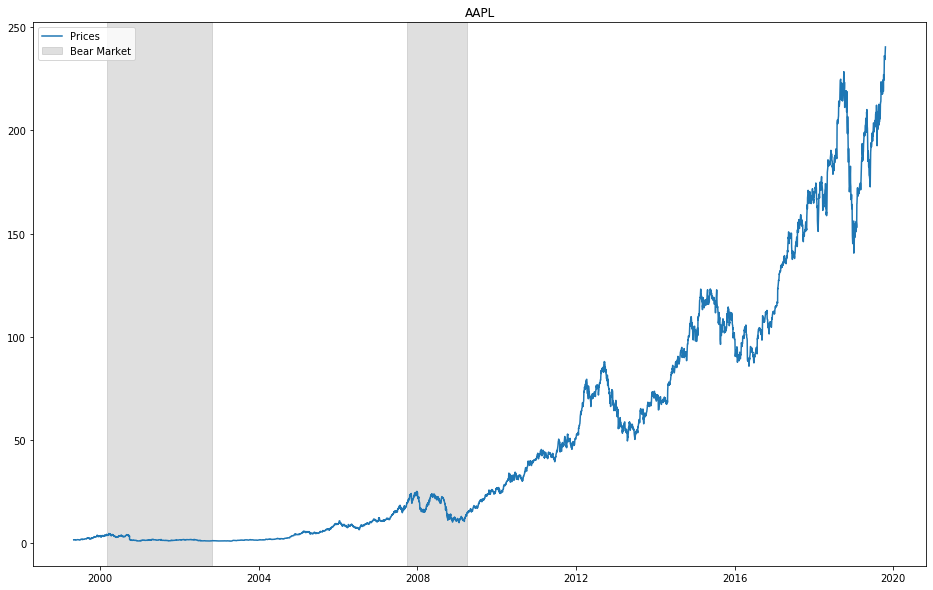

In [32]:
fig, ax = plt.subplots(1, figsize = (16, 10))
plot_stock_prices(ax, data, 'AAPL')
plt.show()

As we can see, over the approximately 20 year period, AAPL has significantly appreciated. AAPL has gone from a struggling computer company to one of the largest technology companies in the world over this time, so the price appreciation is expected. Since none of the other companies selected have gone out of business during this time, we expect all these companies to have similarly appreciated, although probably to a lesser extent.

Let's plot the prices for the other stocks next. Note that each graph below has its own y-axis so the total return over the time period varies quite a bit.

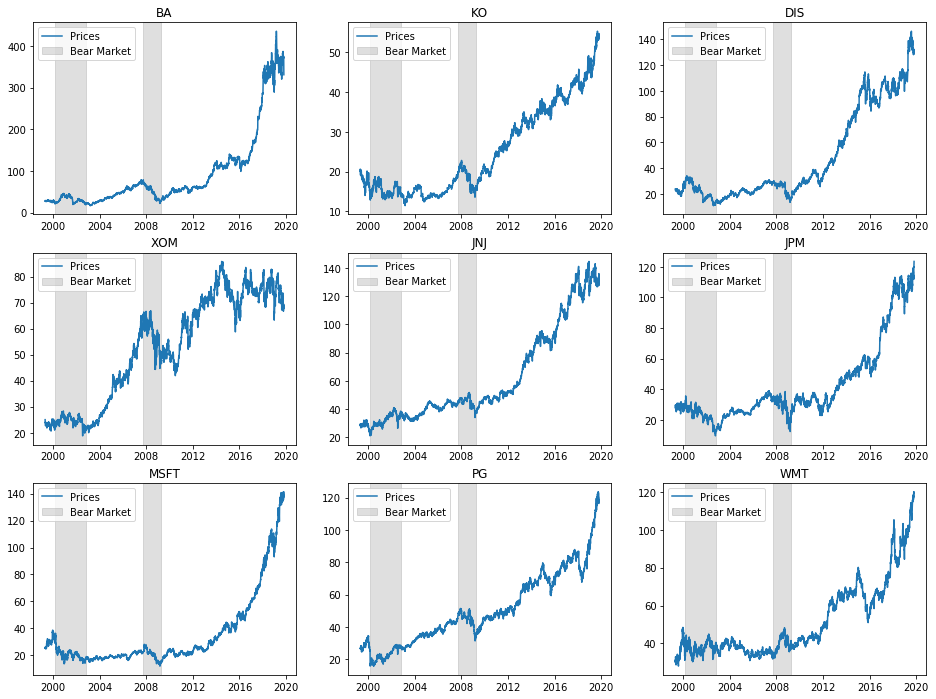

In [8]:
m = 3
n = 3
fig, ax = plt.subplots(m, n, figsize = (16, 12))

for i in range(m):
    for j in range(n):
        plot_stock_prices(ax[i][j], data, data.columns[i * n + j + 1])
plt.show()

While the price time series illustrate what has happened over the 20 year period, the price returns are more interesting. We'll plot the return distributions over the period next.

First, we'll write a function to help calculate the log returns, defined as: $r = ln(S_{t} / S_{t-x})$, where $S_{t}$ is the stock price at time $t$. When $x = 1$, $r$ is a daily return; when $x = 365$, $r$ is the annual return. We'll take a look at both next. 

In [9]:
def log_returns(data, day_offset = 365, fill = True):
    df = data.copy()
    
    if fill:
        date_range = pd.date_range(df.index.min(), df.index.max(), freq = 'D')
        df_pp = df.reindex(date_range).fillna(method = 'ffill')
    else:
        df_pp = df.copy()
    
    df_pp.index = df_pp.index + pd.DateOffset(days = day_offset)
    df_pp.columns = [c + '_PP' for c in df_pp.columns] 
    
    growth_rates = df.join(df_pp, how = 'inner')
    
    for c in data.columns:
        growth_rates[c] = np.log(growth_rates[c] / growth_rates[c + '_PP'])
        
    growth_rates = growth_rates.loc[:, data.columns]
    
    return growth_rates

In [10]:
annual_returns = log_returns(data, day_offset = 365)
daily_returns = log_returns(data, day_offset = 1)

In [11]:
annual_returns.head()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT
2000-05-03,0.906001,-0.131681,-0.336406,0.302106,-0.087637,-0.119842,-0.080991,-0.101014,-0.399918,0.198516
2000-05-04,0.856586,-0.131290,-0.362416,0.286249,-0.043121,-0.111545,-0.069186,-0.116204,-0.396934,0.127977
2000-05-05,0.932960,-0.115751,-0.372932,0.288974,-0.007659,-0.138182,-0.050416,-0.091571,-0.399936,0.183626
2000-05-08,0.875541,-0.165772,-0.322627,0.309930,-0.009070,-0.079023,-0.063568,-0.124430,-0.381856,0.161579
2000-05-09,0.845939,-0.126565,-0.271981,0.322972,-0.019649,-0.058583,-0.087125,-0.161434,-0.349065,0.163562


In [12]:
daily_returns.head()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT
1999-05-05,0.010695,0.022921,0.026009,-0.022695,-0.019037,-0.010582,-0.025365,0.013488,-0.006122,0.023805
1999-05-06,-0.054658,0.018188,-0.019624,-0.006006,-0.029192,0.037890,-0.033347,-0.015026,0.010255,-0.049589
1999-05-07,0.030540,0.017864,-0.020164,0.004008,0.006896,-0.015483,0.010517,0.014268,-0.013001,0.042686
1999-05-10,-0.013827,-0.037639,-0.010237,-0.008368,-0.001931,-0.029024,0.007879,0.007937,-0.007616,0.009784
1999-05-11,-0.011111,-0.014172,-0.001791,-0.010475,-0.009147,-0.006123,0.012579,0.002256,0.015175,0.045846


Now that we have the log return data, we'll write a function to plot the return distributions. 

In [13]:
def plot_return_histogram(ax, data, ticker, bins = 250, density = True, alpha = 1.0, plot_normal = True):
    returns = data.loc[:, ticker]
    ax.title.set_text(ticker)
    
    ax.hist(returns, bins = bins, density = density, alpha = alpha, label = 'Historical Returns')

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 500)
    
    if plot_normal:
        mean = np.mean(returns)
        std = np.std(returns)

        pdf = stats.norm.pdf(x, mean, std)
        ax.plot(x, pdf, linewidth = 2, label = 'Fit Normal, mu = {:.2f}, sigma = {:.2f}'.format(mean, std))

    ax.legend(loc = 'upper left')

Again, we'll look at AAPL first, plotting the annual returns first (the graph on the left) and then the daily returns (the graph on the right). 

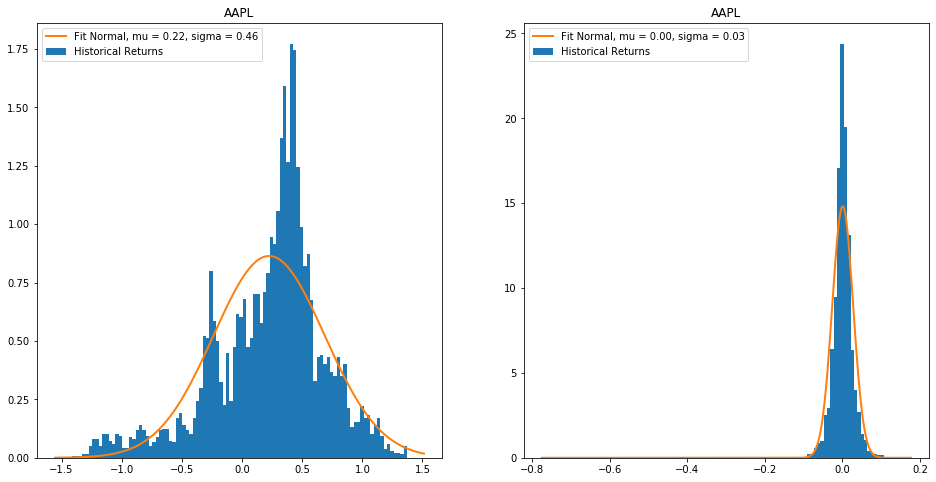

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_return_histogram(ax[0], annual_returns, 'AAPL', bins = 100)
plot_return_histogram(ax[1], daily_returns, 'AAPL', bins = 100)
plt.show()

In addition to the historical return histograms, we've also overlaid the histograms with the Gaussian distributions based on the mean and variance of the returns. As we can see, the returns are far from normally distributed. It is well known that the normal distribution is not a perfect model of stock price returns. Generally, actual return distributions have higher kurtosis (i.e., have fatter tails) and are more peaked.

While daily returns are closely centered around zero, which we would expect as daily prices generally do not fluctuate as much, the annual return distribution is more complex. The mean annual return is 0.22 with a standard deviation of 0.46, compared to a standard deviation of 0.03 for the daily returns. The distribution also appears somewhat multimodal. 

Since we know stocks behave differently during recessions and periods of volatility, we'll bifurcate the returns into two different regimes - a bear market regime, for the time periods discussed above, and a bull market regime, which will just be all the other periods - and we'll plot the return distributions for each regime.

In [15]:
annual_returns.loc['2000-03-01':'2002-10-31', 'regime'] = 1
annual_returns.loc['2007-10-01':'2009-03-31', 'regime'] = 1
annual_returns['regime'] = annual_returns['regime'].fillna(0).astype(int)
annual_returns.head()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT,regime
2000-05-03,0.906001,-0.131681,-0.336406,0.302106,-0.087637,-0.119842,-0.080991,-0.101014,-0.399918,0.198516,1
2000-05-04,0.856586,-0.131290,-0.362416,0.286249,-0.043121,-0.111545,-0.069186,-0.116204,-0.396934,0.127977,1
2000-05-05,0.932960,-0.115751,-0.372932,0.288974,-0.007659,-0.138182,-0.050416,-0.091571,-0.399936,0.183626,1
2000-05-08,0.875541,-0.165772,-0.322627,0.309930,-0.009070,-0.079023,-0.063568,-0.124430,-0.381856,0.161579,1
2000-05-09,0.845939,-0.126565,-0.271981,0.322972,-0.019649,-0.058583,-0.087125,-0.161434,-0.349065,0.163562,1


In [16]:
daily_returns.loc['2000-03-01':'2002-10-31', 'regime'] = 1
daily_returns.loc['2007-10-01':'2009-03-31', 'regime'] = 1
daily_returns['regime'] = daily_returns['regime'].fillna(0).astype(int)
daily_returns.head()

,AAPL,BA,KO,DIS,XOM,JNJ,JPM,MSFT,PG,WMT,regime
1999-05-05,0.010695,0.022921,0.026009,-0.022695,-0.019037,-0.010582,-0.025365,0.013488,-0.006122,0.023805,0
1999-05-06,-0.054658,0.018188,-0.019624,-0.006006,-0.029192,0.037890,-0.033347,-0.015026,0.010255,-0.049589,0
1999-05-07,0.030540,0.017864,-0.020164,0.004008,0.006896,-0.015483,0.010517,0.014268,-0.013001,0.042686,0
1999-05-10,-0.013827,-0.037639,-0.010237,-0.008368,-0.001931,-0.029024,0.007879,0.007937,-0.007616,0.009784,0
1999-05-11,-0.011111,-0.014172,-0.001791,-0.010475,-0.009147,-0.006123,0.012579,0.002256,0.015175,0.045846,0


As we can see below, the condititional distributions (the return distribution given the market is in one of the two regimes) of the two different regimes are quite different. Most noticeably, the mean return is positive in the bull market regime, 0.31, and negative in the bear market regime, -0.12, which we would expect. The variance of the bear market regime distribution is much higher - 0.62 versus 0.36 - which is consistent with markets having higher volatility during bear markets/recessions.

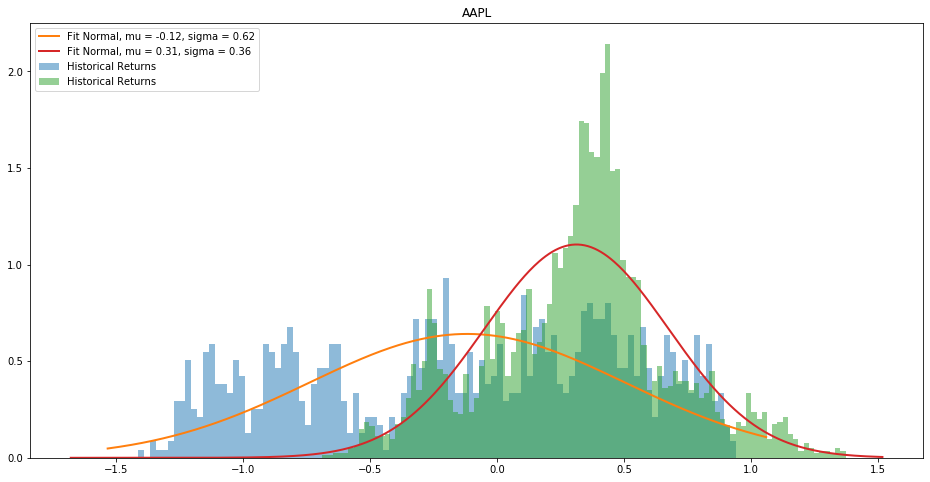

In [17]:
fig, ax = plt.subplots(1, figsize = (16, 8))
plot_return_histogram(ax, annual_returns.loc[annual_returns['regime'] == 1, :], 'AAPL', bins = 100, alpha = 0.5)
plot_return_histogram(ax, annual_returns.loc[annual_returns['regime'] == 0, :], 'AAPL', bins = 100, alpha = 0.5)
plt.show()

Let's see how the return distributions look for the other 9 stocks.

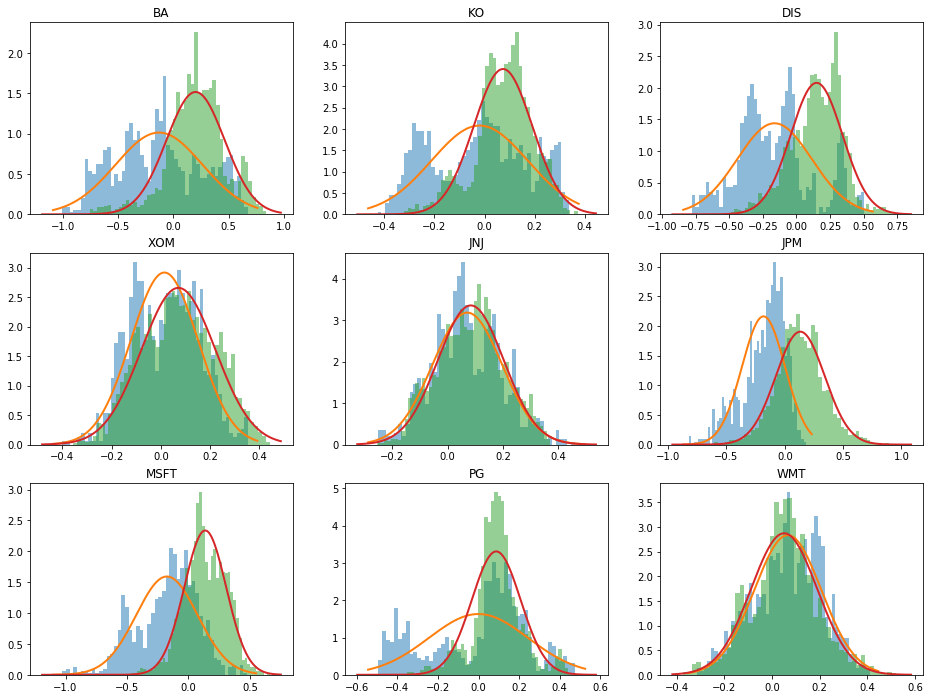

In [18]:
m = 3
n = 3
fig, ax = plt.subplots(m, n, figsize = (16, 12))

for i in range(m):
    for j in range(n):
        plot_return_histogram(ax[i][j], annual_returns.loc[annual_returns['regime'] == 1, :], 
                              data.columns[i * n + j + 1], bins = 50, alpha = 0.5)
        
        plot_return_histogram(ax[i][j], annual_returns.loc[annual_returns['regime'] == 0, :], 
                              data.columns[i * n + j + 1], bins = 50, alpha = 0.5)
        
        ax[i][j].get_legend().remove()
plt.show()

The return distributions for each stock are quite a bit different. For XOM, JNJ, and WMT, the conditional distributions are quite similar. XOM is an energy company and JNJ is a healthcare company. Unlike technology companies, such as AAPL or MSFT, or entertainment companies, such as DIS, the demand for energy and healthcare does not fluctuate much during a recession, so we expect companies in these industries to be more "recession proof" (i.e, less senstive to the business cycle). WMT is a large, low cost retailer; consumers switch to lower costs substitutes during recessions, so WMT is also, understandably, less senstive to the business cycle.

Other companies, such as AAPL, DIS, and MSFT, have more distinct conditional distributions. During recessions, consumers may put off buying non-essential products, such as updating computers or cell phones, or shift their spending from discretionary items, such as movies, to more essential items, such as gasoline. Therefore, these companies are more sensitive the business cycle and we can see this in their return distributions.

Now that we have a sense for the individual return distributions for each stock, we'll look at the correlations between assets. When holding a portfolio of assets, a trader can reduce portfolio variance by holding assets with low or negative correlation (i.e., holding a diverse portfolio of assets). This is a key insight of modern portfolio theory (MPT). MPT is a little outside the scope of this project, but the interested reader can find more details here: https://en.wikipedia.org/wiki/Modern_portfolio_theory.

Again, we'll write a function to help us visualize the correlations.

In [19]:
def plot_correlation_heatmap(ax, data, annot = False, scale = (0.0, 1.0)):
    correlation_matrix = np.corrcoef(data.values.transpose())
    
    labels = data.columns
    sns.heatmap(correlation_matrix, ax = ax, cmap = sns.cm.rocket_r, linewidth = 0.25, 
                xticklabels = labels, yticklabels = labels, annot = annot,
                vmin = scale[0], vmax = scale[1])
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

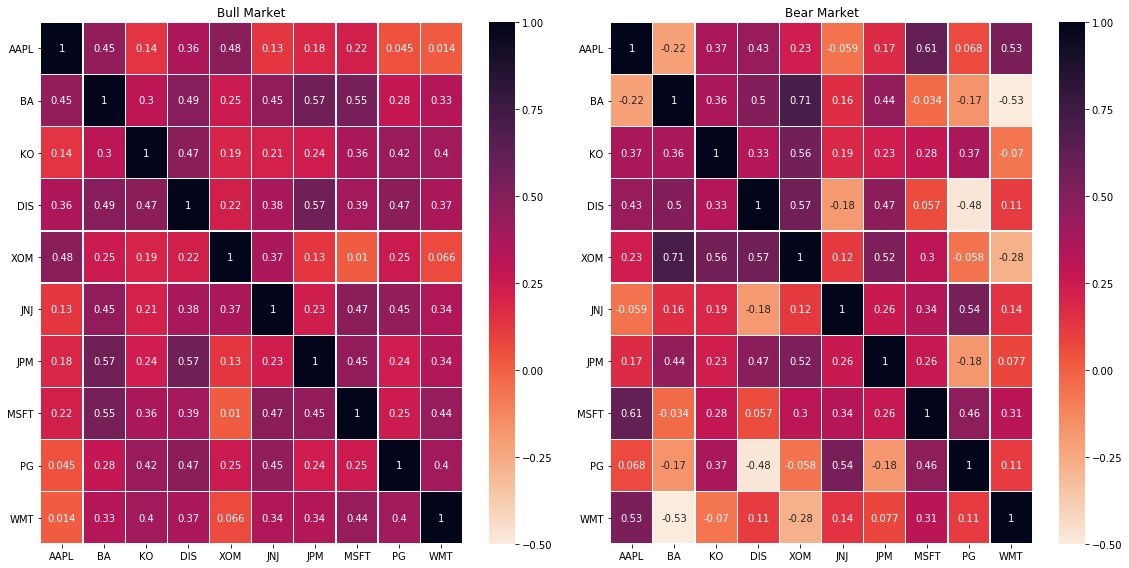

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

ax[0].title.set_text('Bull Market')
plot_correlation_heatmap(ax[0], annual_returns.loc[annual_returns['regime'] == 0, annual_returns.columns.drop('regime')], 
                         annot = True, scale = (-0.5, 1.0))

ax[1].title.set_text('Bear Market')
plot_correlation_heatmap(ax[1], annual_returns.loc[annual_returns['regime'] == 1, annual_returns.columns.drop('regime')], 
                         annot = True, scale = (-0.5, 1.0))

plt.tight_layout()
plt.show()

All correlation matrices are symetric, as the correlation between random variables $X$ and $Y$ is the same as correlation between $Y$ and $X$. The correlation between $X$ and $X$ is always 1.0, so the diagonal is always 1.0. As such, we can either focus on the lower or upper half of the matrices. Heatmaps are a convenient way to visualize the correlation matrix for multiple variables (in this case the 10 stocks). 

The correlation between assets is quite a bit different in each regime. For similar companies, such as AAPL and MSFT, the correlation increases during the bear market regime, increasing from 0.22 to 0.61. For dissimilar companies, the correlation may actually flip signs; for example, the correlation between WMT and BA decreases from 0.33 to -0.53. Therefore, we can reduce portfolio variance by holding WMT and BA during a bear market, but holding both AAPL and MSFT may increase portfolio variance over the same time period.

We hope that our reinforcement learning agent will be able to learn these kind of distinctions between assets from the data.

**Other Financial Data**

Now that we have explored the stocks that the agent will be allowed to trade, we'll look at some other financial time series that the agent will have access to in order to help it make informed trading decisions. 

In [34]:
meta_data_file = './marketenv/environments/market_data/market_meta_data.csv'
meta_data = pd.read_csv(meta_data_file)
meta_data

,id,title,last_updated,popularity,frequency,frequency_short,observation_start,observation_end,seasonal_adjustment,seasonal_adjustment_short,units,units_short,notes,realtime_start,realtime_end
0,T10Y2Y,10-Year Treasury Constant Maturity Minus 2-Yea...,2019-10-23 16:02:01-05,100,Daily,D,1976-06-01,2019-10-23,Not Seasonally Adjusted,NSA,Percent,%,"Starting with the update on June 21, 2019, the...",2019-10-23,2019-10-23
1,DGS10,10-Year Treasury Constant Maturity Rate,2019-10-23 15:27:02-05,94,Daily,D,1962-01-02,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,For further information regarding treasury con...,2019-10-23,2019-10-23
2,DGS5,5-Year Treasury Constant Maturity Rate,2019-10-23 15:27:02-05,77,Daily,D,1962-01-02,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,For further information regarding treasury con...,2019-10-23,2019-10-23
3,DGS3,3-Year Treasury Constant Maturity Rate,2019-10-23 15:27:03-05,64,Daily,D,1962-01-02,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,For further information regarding treasury con...,2019-10-23,2019-10-23
4,DGS2,2-Year Treasury Constant Maturity Rate,2019-10-23 15:27:02-05,76,Daily,D,1976-06-01,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,For further information regarding treasury con...,2019-10-23,2019-10-23
5,DGS1,1-Year Treasury Constant Maturity Rate,2019-10-23 15:28:02-05,80,Daily,D,1962-01-02,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,For further information regarding treasury con...,2019-10-23,2019-10-23
6,WILL5000INDFC,Wilshire 5000 Total Market Full Cap Index,2019-10-23 07:32:01-05,67,"Daily, Close",D,1970-12-31,2019-10-22,Not Seasonally Adjusted,NSA,Index,Index,The observations for the Wilshire 5000 Total M...,2019-10-23,2019-10-23
7,NASDAQCOM,NASDAQ Composite Index,2019-10-23 18:46:01-05,63,Daily,D,1971-02-05,2019-10-23,Not Seasonally Adjusted,NSA,"Index Feb 5, 1971=100","Index Feb 5, 1971=100",The observations for the NASDAQ Composite Inde...,2019-10-23,2019-10-23
8,BAMLH0A0HYM2,ICE BofAML US High Yield Master II Option-Adju...,2019-10-23 08:00:01-05,92,"Daily, Close",D,1996-12-31,2019-10-22,Not Seasonally Adjusted,NSA,Percent,%,The ICE BofAML Option-Adjusted Spreads (OASs) ...,2019-10-23,2019-10-23
9,DCOILWTICO,Crude Oil Prices: West Texas Intermediate (WTI...,2019-10-23 14:01:01-05,80,Daily,D,1986-01-02,2019-10-21,Not Seasonally Adjusted,NSA,Dollars per Barrel,$ per Barrel,"Definitions, Sources and Explanatory Notes (ht...",2019-10-23,2019-10-23


The 14 time series collected include a variety of different metrics: general stock indices, such as the NASDAQ, interest rates and spreads, such as the 10-year Treasury rate and the 10-year minus 2-year Treasure rate spread, volatility indices, such as the VIX, etc. The individual 10-year to 1-year Treasury rates also make up the yield curve. Investors look at these metrics when evaluating market conditions and use this information, along with company specific information, to make trade decisions. While the items above are quite broad, this is just a tiny fraction of the non-equity financial information available, so there may be additional/better metrics that the agent could use to make decisions. However, this should be a decent starting point.

In [8]:
data = pd.read_csv(data_file, index_col = 0)
data.index = pd.to_datetime(data.index)
data = data.iloc[:, 90:]
data.head()

,T10Y2Y,DGS10,DGS5,DGS3,DGS2,DGS1,WILL5000INDFC,NASDAQCOM,BAMLH0A0HYM2,DCOILWTICO,DAAA,BAA10Y,VIXCLS,VXDCLS
date,,,,,,,,,,,,,,
1999-05-04,0.30,5.42,5.30,5.20,5.12,4.80,39.15,2485.12,4.65,18.94,6.83,2.21,25.62,26.45
1999-05-05,0.31,5.40,5.27,5.16,5.09,4.75,39.52,2534.45,4.71,18.89,6.81,2.21,25.19,25.60
1999-05-06,0.33,5.52,5.39,5.26,5.19,4.79,39.13,2472.28,4.61,18.23,6.90,2.17,27.44,27.18
1999-05-07,0.35,5.54,5.40,5.27,5.19,4.78,39.44,2503.62,4.62,18.23,6.92,2.17,25.36,25.45
1999-05-10,0.39,5.54,5.38,5.24,5.15,4.77,39.43,2526.39,4.67,18.57,6.87,2.13,26.62,24.78


We'll take a look at a couple of these metrics to get a sense for how they might inform our agent.

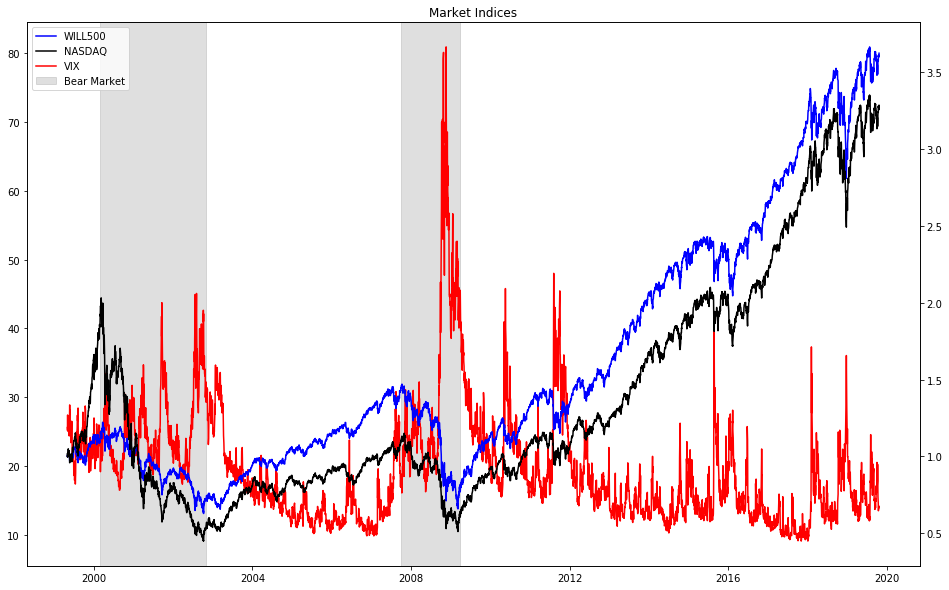

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

WILL5000 = data.loc[:, 'WILL5000INDFC']
WILL5000 = WILL5000 / WILL5000.iloc[0]

NASDAQ = data.loc[:, 'NASDAQCOM']
NASDAQ = NASDAQ / NASDAQ.iloc[0]

VIX = data.loc[:, 'VIXCLS']

ax.title.set_text('Market Indices')
ax2 = ax.twinx()

line1 = ax2.plot(data.index, WILL5000, label = 'WILL500', color = 'b')
line2 = ax2.plot(data.index, NASDAQ, label = 'NASDAQ', color = 'k')
line3 = ax.plot(data.index, VIX, label = 'VIX', color = 'r')

spans = ax.axvspan('2000-03-01', '2002-10-31', alpha = 0.25, color = 'grey', label = 'Bear Market')
ax.axvspan('2007-10-01', '2009-03-31', alpha = 0.25, color = 'grey')

plots = [line1[0], line2[0], line3[0], spans]
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper left')
plt.show()

The above graph plots the WILL5000 and NASDAQ, two broad, equity market indices, against the VIX, a widely used measure of the market volatility; the VIX is calculated using S&P500 options, but, as we can see above, broad market indices generally move together. For those unfamiliar with volatility indices, you can read more about the VIX here: http://www.cboe.com/vix.

As we can see from the above time series, there is a negative correlation between the VIX and the market indices: when markets are declining, the VIX spikes up. This is especially apparent during the 2008 recession (bear market above). 

The WILL5000 time series looks a lot like the time series for the stocks chosen. We'll take a look at the return distribution for this series next.

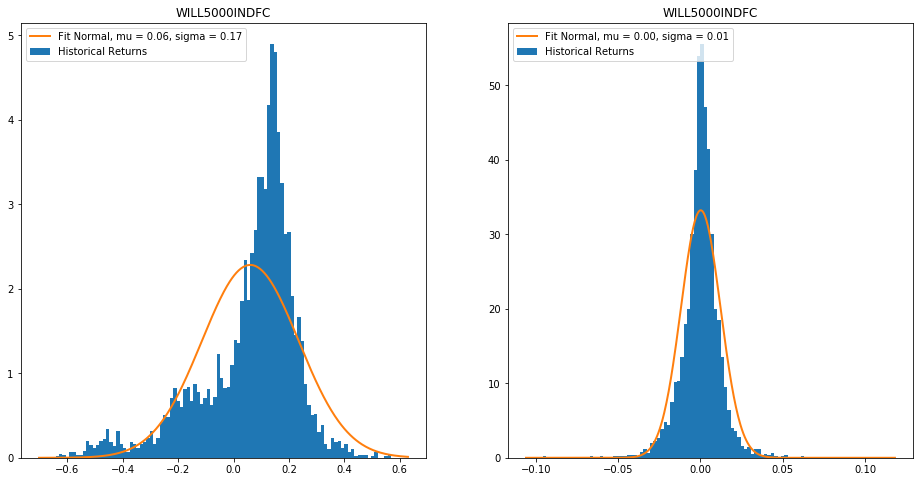

In [36]:
annual_returns = log_returns(data, day_offset = 365)
daily_returns = log_returns(data, day_offset = 1)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_return_histogram(ax[0], annual_returns, 'WILL5000INDFC', bins = 100)
plot_return_histogram(ax[1], daily_returns, 'WILL5000INDFC', bins = 100)
plt.show()

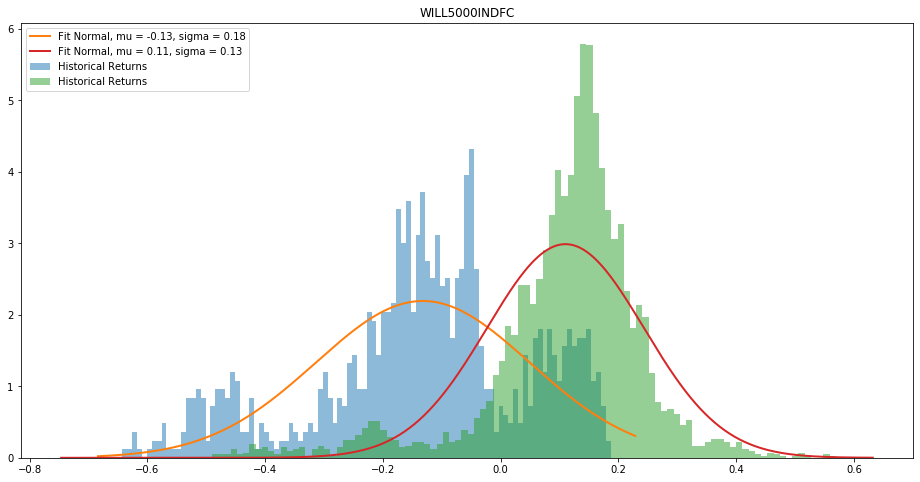

In [38]:
annual_returns.loc['2000-03-01':'2002-10-31', 'regime'] = 1
annual_returns.loc['2007-10-01':'2009-03-31', 'regime'] = 1
annual_returns['regime'] = annual_returns['regime'].fillna(0).astype(int)

fig, ax = plt.subplots(1, figsize = (16, 8))
plot_return_histogram(ax, annual_returns.loc[annual_returns['regime'] == 1, :], 'WILL5000INDFC', bins = 100, alpha = 0.5)
plot_return_histogram(ax, annual_returns.loc[annual_returns['regime'] == 0, :], 'WILL5000INDFC', bins = 100, alpha = 0.5)
plt.show()

Unsurprisingly, the return distribution for the WILL5000 is very similar to the distributions for the 10 stocks above. The distributions are non-normal, with higher kurtosis (i.e., fatter tails), more peaked-ness, and somewhat multimodal (especially the conditional distribution for the bear market regime). 

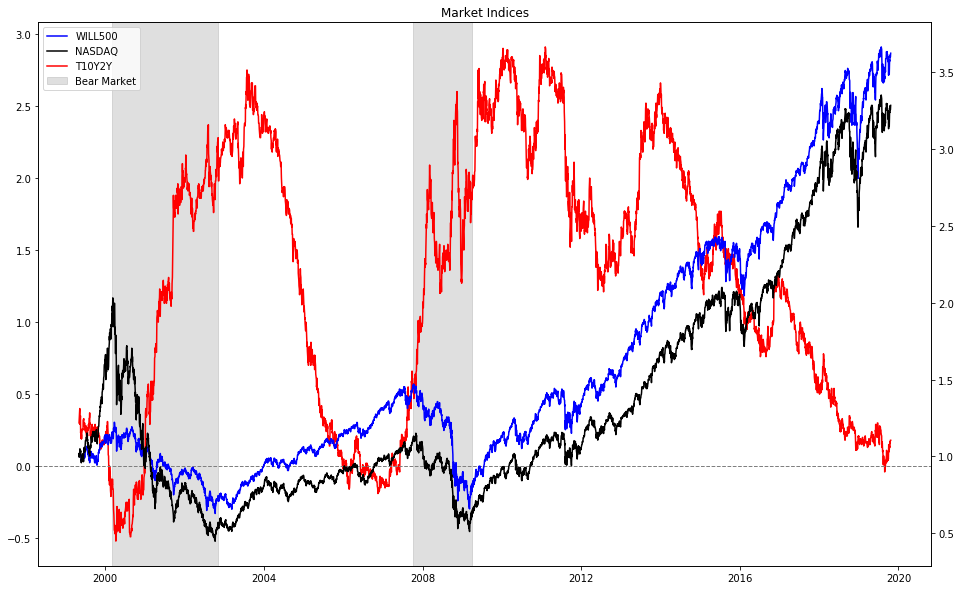

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

WILL500 = data.loc[:, 'WILL5000INDFC']
WILL500 = WILL500 / WILL500.iloc[0]

NASDAQ = data.loc[:, 'NASDAQCOM']
NASDAQ = NASDAQ / NASDAQ.iloc[0]

T10Y2Y = data.loc[:, 'T10Y2Y']

ax.title.set_text('Market Indices')
ax2 = ax.twinx()

line1 = ax2.plot(data.index, WILL500, label = 'WILL500', color = 'b')
line2 = ax2.plot(data.index, NASDAQ, label = 'NASDAQ', color = 'k')
line3 = ax.plot(data.index, T10Y2Y, label = 'T10Y2Y', color = 'r')

spans = ax.axvspan('2000-03-01', '2002-10-31', alpha = 0.25, color = 'grey', label = 'Bear Market')
ax.axvspan('2007-10-01', '2009-03-31', alpha = 0.25, color = 'grey')
ax.axhline(0, linestyle = '--', color = 'grey', linewidth = 1.0)

plots = [line1[0], line2[0], line3[0], spans]
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper left')
plt.show()

This next graph plots the broad market indices against the 10-year versus 2-year Treasury spread (T10Y2Y). This spread is one measure of the shape of the yield curve. The yield curve, which you can read more about here, https://en.wikipedia.org/wiki/Yield_curve, is usually upward sloping, with longer term maturities, such as 10-year Treasuries, commanding higher rates than shorter term maturities, such as 2-year Treasuries. As such, the T10Y2Y is usually positive. 

However, many recent recessions, including the two highlighted above (again, the bear market bands), are preceded by an inverted yield curve. We can see this in the above time series as the T10Y2Y dips below 0 in early 2000, at the beginning of the bear market, and in 2007, before the housing bubble burst and the subsequent 2008 recession. Like the VIX, the yield curve is a closely watched metric for many investors, so we hope the agent can also use these other financial metrics to help make informed decisions.

This concludes the data EDA. We'll use this data to create the market environment that will be used to train and evaluate our reinforcement learning agent in the next notebook.